In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('proj_train.csv', index_col="Id")
df_test = pd.read_csv('proj_test.csv', index_col="Id")

In [3]:
y_train = df_train.SalePrice
df_train = df_train.drop(columns='SalePrice')

In [4]:
df_train._get_numeric_data().columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'PoolArea', 'YrSold'],
      dtype='object')

In [5]:
df_train.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive'],
      dtype='object')

In [6]:
print(len(df_train._get_numeric_data().columns))
print(len(df_train.select_dtypes(include='object').columns))

26
35


In [7]:
print(df_train.shape)
print(df_test.shape)

(1460, 61)
(1459, 61)


# Pre-processing

In [8]:
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing

Electrical        1
YrSold            1
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
BsmtExposure     38
BsmtFinType2     38
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
LotFrontage     259
FireplaceQu     690
dtype: int64

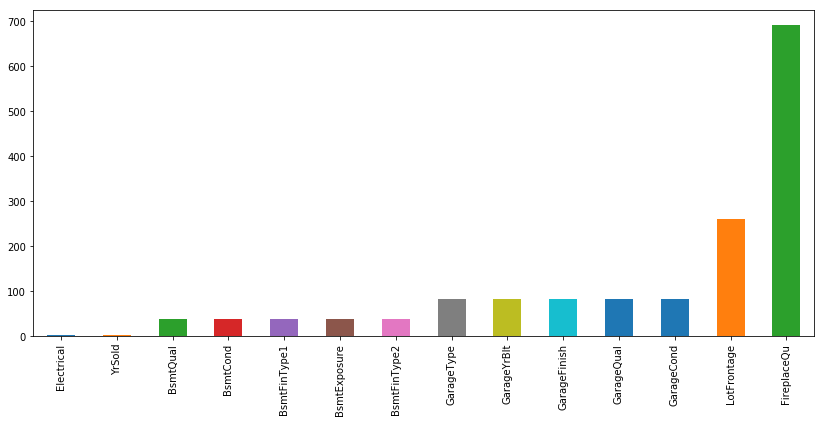

In [9]:
_, axes = plt.subplots(figsize=(14, 6))
missing.plot.bar()

In [10]:
#impute categorical features
categorical_features = df_train.select_dtypes(include='object').columns
df_train[categorical_features] = df_train[categorical_features].fillna('None')
df_test[categorical_features] = df_test[categorical_features].fillna('None')

In [11]:
#imputing numerical features
from sklearn.preprocessing import Imputer

# Replace NaN with corresponding Neighborhood Median
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
df_test["LotFrontage"] = df_test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
    
# Replace NaN with Feature Mean 
numerical_features = df_train.select_dtypes(include='number').columns
my_imputer = Imputer()
df_train[numerical_features] = my_imputer.fit_transform(df_train[numerical_features])
df_test[numerical_features] = my_imputer.transform(df_test[numerical_features])


In [12]:
#train test join 
idx_split = df_train.shape[0]
df_train = df_train.append(df_test)

In [13]:
#facorization
NumStr = ["MSSubClass","YrSold","YearBuilt","YearRemodAdd","GarageYrBlt"]
for col in NumStr:
    df_train[col]=df_train[col].astype(str)
    
non_ordinal_features = ['LandSlope','Utilities','MSZoning', 'Street','LotShape','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle', 'RoofStyle','RoofMatl','Exterior1st', 'Exterior2nd','Foundation', 'BsmtExposure','BsmtFinType1','BsmtFinType2', 'CentralAir', 'Electrical','Functional', 'GarageType','GarageFinish','PavedDrive', "MSSubClass","YrSold","YearBuilt","YearRemodAdd","GarageYrBlt"]
ordinal_features = df_train.select_dtypes(include='object').columns.drop(non_ordinal_features)

In [14]:
# Non-Ordinal Variables
dummies = pd.get_dummies(df_train.loc[:,non_ordinal_features], drop_first=True)
df_train = pd.concat([df_train,dummies], axis=1)
df_train = df_train.drop(non_ordinal_features,axis=1)

In [15]:
# Ordinal Variables
def cat_to_num(x):
    if x=='Ex':
        return 5
    if x=='Gd':
        return 4
    if x=='TA':
        return 3
    if x=='Fa':
        return 2
    if x=='Po':
        return 1
    if x=='None':
        return 0

df_train.loc[:,ordinal_features] = df_train.loc[:,ordinal_features].applymap(cat_to_num)

In [16]:
X = df_train.loc[:idx_split, :]
X_test = df_train.loc[idx_split+1:, :]

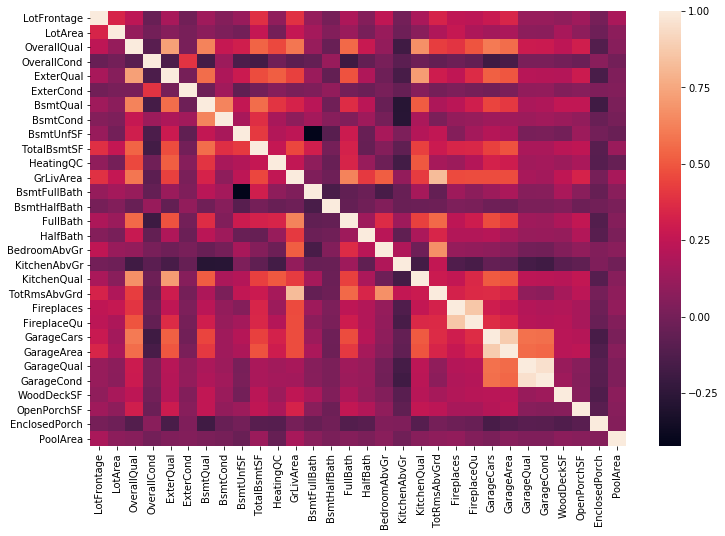

In [17]:
#correlation 
_, ax = plt.subplots(ncols=1, figsize=(12,8))
corr_matrix = X.drop(dummies,axis=1).corr()
sns.heatmap(corr_matrix);

Text(0,0.5,'Sale Price')

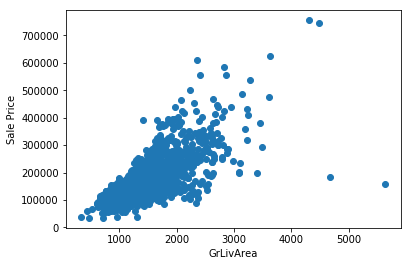

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = X['GrLivArea'], y = y_train)
plt.xlabel('GrLivArea')
plt.ylabel('Sale Price')

In [19]:
#handling outliers
print(X[(X['GrLivArea']>4000) & (y_train<300000)].index)

Int64Index([524, 1299], dtype='int64', name='Id')


In [20]:
X = X.drop(X[(X['GrLivArea']>4000) & (y_train<300000)].index)
y_train = y_train.drop([524, 1299])

Text(0,0.5,'Sale Price')

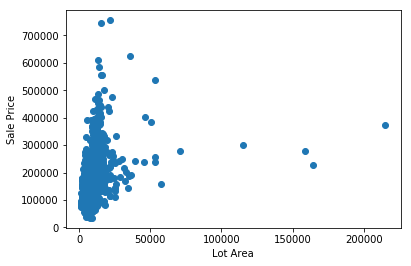

In [21]:
fig, ax = plt.subplots()
ax.scatter(x = X['LotArea'], y = y_train)
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')

In [22]:
print(X[(X['LotArea']>100000) & (y_train<500000)].index)

Int64Index([250, 314, 336, 707], dtype='int64', name='Id')


In [23]:
X = X.drop(X[(X['LotArea']>100000) & (y_train<500000)].index)
y_train = y_train.drop([250, 314, 336, 707])

Text(0,0.5,'Sale Price')

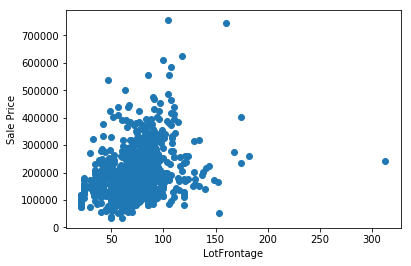

In [24]:
fig, ax = plt.subplots()
ax.scatter(x = X['LotFrontage'], y = y_train)
plt.xlabel('LotFrontage')
plt.ylabel('Sale Price')

In [25]:
print(X[(X['LotFrontage']>250) & (y_train<500000)].index)

Int64Index([935], dtype='int64', name='Id')


In [26]:
X = X.drop(X[(X['LotFrontage']>250) & (y_train<500000)].index)
y_train = y_train.drop([935])

Text(0,0.5,'Sale Price')

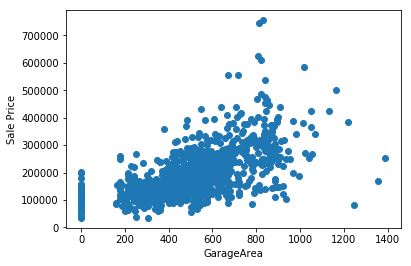

In [27]:
fig, ax = plt.subplots()
ax.scatter(x = X['GarageArea'], y = y_train)
plt.xlabel('GarageArea')
plt.ylabel('Sale Price')

In [28]:
print(X[(X['GarageArea']>1200) & (y_train<300000)].index)

Int64Index([582, 1062, 1191], dtype='int64', name='Id')


In [29]:
print(X[(X['GarageArea']<1000) & (y_train>700000)].index)

Int64Index([692, 1183], dtype='int64', name='Id')


In [30]:
X = X.drop(X[(X['GarageArea']>1200) & (y_train<300000)].index)
X = X.drop(X[(X['GarageArea']<1000) & (y_train>700000)].index)
y_train = y_train.drop([582, 1062, 1191, 692, 1183])

c:\users\aadarsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0,0.5,'Frequency')

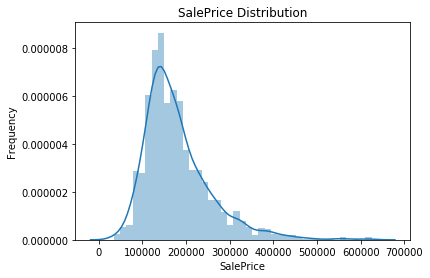

In [31]:
sns.distplot(y_train)
plt.title('SalePrice Distribution')
plt.ylabel('Frequency')

In [32]:
print("Skewness: {:.3f}".format(y_train.skew()))

Skewness: 1.583


In [33]:
y_train = np.log1p(y_train)

Text(0,0.5,'Frequency')

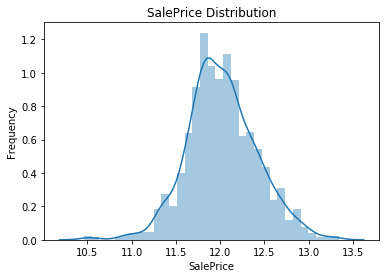

In [34]:
sns.distplot(y_train)
plt.title('SalePrice Distribution')
plt.ylabel('Frequency')

In [35]:
print("Skewness: {:.3f}".format(y_train.skew()))

Skewness: 0.071


In [36]:
from collections import Counter
Counter(X.GarageCars)

Counter({2.0: 818, 3.0: 176, 1.0: 369, 0.0: 81, 4.0: 4})

In [37]:
Counter(X.FireplaceQu)

Counter({0: 689, 3: 309, 4: 374, 2: 33, 5: 23, 1: 20})

In [38]:
Counter(X.GarageCond)

Counter({3: 1314, 2: 35, 0: 81, 4: 9, 1: 7, 5: 2})

In [39]:
multicol_features = ['GarageCars', 'FireplaceQu', 'GarageCond']
X = X.drop(multicol_features, axis = 1)
X_test = X_test.drop(multicol_features, axis = 1)

In [40]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)

X[X.columns] = scaler.transform(X[X.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])


# Modelling

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
Xtr, Xte, ytr, yte = train_test_split(X,y_train,test_size=0.3)

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Lasso

In [44]:
from sklearn.linear_model import Lasso

In [45]:
rgr_ls = Lasso(fit_intercept = True)
param_grid = {
    "alpha": [0.0002, 0.0003, 0.0005, 0.0008, 0.001]
}
searchCV = GridSearchCV(rgr_ls, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
searchCV.fit(X, y_train)
np.sqrt(searchCV.best_score_*-1)

0.1161121792606314

In [46]:
searchCV.best_estimator_

Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [47]:
lasso = Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [48]:
lasso.fit(X, y_train)
lasso_pred = lasso.predict(X_test)
lasso_pred = np.exp(lasso_pred)

# Gradient Boosting

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

In [50]:
gbr = GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,max_features='sqrt',min_samples_leaf=15, min_samples_split=10,loss='huber')

In [51]:
gbr.fit(Xtr, ytr)
y_gbr_pred = gbr.predict(Xte)
print(r2_score(yte,y_gbr_pred))

0.890586579560559


In [52]:
gbr_pred = gbr.predict(X_test)
gbr_pred = np.exp(gbr_pred)

# XGBoost

In [53]:
import xgboost as xgb

In [54]:
model_xgb = xgb.XGBRegressor(gamma=0.025,n_estimators=1500)

In [55]:
model_xgb.fit(Xtr, ytr)
y_xgb_pred = model_xgb.predict(Xte)
print(r2_score(yte,y_xgb_pred))

0.8875898621111054


In [56]:
xgb_pred = model_xgb.predict(X_test)
xgb_pred = np.exp(xgb_pred)

# KNN

In [57]:
from sklearn.neighbors import KNeighborsRegressor

In [58]:
knn = KNeighborsRegressor(n_neighbors=7,weights='distance',metric='manhattan',algorithm='auto')

In [59]:
knn.fit(Xtr, ytr)
y_knn_pred = knn.predict(Xte)
print(r2_score(yte,y_knn_pred))

0.7499526798966667


In [60]:
knn_pred = knn.predict(X_test)
knn_pred = np.exp(knn_pred)

# Linear Regression

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [62]:
slr1 = LinearRegression(normalize=True)
quadratic = PolynomialFeatures(degree=2)
Xtr_quad = quadratic.fit_transform(Xtr)
Xte_quad = quadratic.fit_transform(Xte)
slr1.fit(Xtr_quad, ytr)
y_lr_pred = slr1.predict(Xte_quad)
print(r2_score(yte,y_lr_pred))

0.8423971970126678


In [63]:
X_test_quad = quadratic.fit_transform(X_test)
qlr_pred = slr1.predict(X_test_quad)
qlr_pred = np.exp(qlr_pred)

# Ridge

In [64]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=0.0001, normalize=True, max_iter=10000000, tol=500, random_state=0)
rr.fit(Xtr, ytr)
y_rr_pred = rr.predict(Xte)
print(r2_score(yte,y_rr_pred))

0.7976953335679996


In [65]:
rr_pred = rr.predict(X_test)
rr_pred = np.exp(rr_pred)

# Elastic Net

In [66]:
from sklearn.linear_model import ElasticNet

In [67]:
eln = ElasticNet(alpha=0.0001, l1_ratio=0.5, normalize=False, warm_start=True, tol=0.001, random_state=0)
eln.fit(Xtr, ytr)
y_en_pred = eln.predict(Xte)
print(r2_score(yte,y_en_pred))

0.8786806279064129


In [68]:
eln_pred = eln.predict(X_test)
eln_pred = np.exp(eln_pred)

# Light GBM

In [69]:
import lightgbm as lgbm

In [70]:
lgbmr = lgbm.LGBMRegressor(application='regression',boosting='dart',num_boost_round=1000,learning_rate=0.05,metric='mse',
                           max_depth=5,bagging_fraction=0.7,)

In [71]:
lgbmr.fit(Xtr, ytr)
y_lgb_pred = lgbmr.predict(Xte)
print(r2_score(yte,y_lgb_pred))

c:\users\aadarsh\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.4196569690189512


In [72]:
lgbmr_pred = lgbmr.predict(X_test)
lgbmr_pred = np.exp(lgbmr_pred)

# Averaging

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [74]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [75]:
def r2(model):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    print(r2_score(yte,y_pred))

In [76]:
averaged_models = AveragingModels(models = (lasso, knn, gbr, rr, eln))
r2(averaged_models)

0.8879638988055798


In [77]:
avg_pred = averaged_models.predict(X_test)
avg_pred = np.exp(avg_pred)

# Stacking

In [78]:
from sklearn.model_selection import StratifiedKFold

In [79]:
def Stacking(model,train,y,test,n_fold):
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((test.shape[0],1),float)
    train_pred=np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y.values):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))
        test_pred=np.append(test_pred,model.predict(test))
    return test_pred.reshape(-1,1),train_pred

In [80]:
test_pred1 ,train_pred1=Stacking(model=knn,n_fold=10, train=Xtr,test=Xte,y=ytr)
train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (knn, eln, averaged_models),
                                                 meta_model = lasso)
r2(stacked_averaged_models)

# Final

In [81]:
lasso_pred, xgb_pred, knn_pred, qlr_pred, rr_pred, eln_pred, lgbmr_pred, gbr_pred, avg_pred

(array([116920.84259159, 155131.24486912, 182786.50530935, ...,
        171604.27281706, 110595.07858936, 212898.15940361]),
 array([128512.02, 165627.42, 179610.36, ..., 158711.6 , 117563.75,
        208697.28], dtype=float32),
 array([128807.48564384, 142192.16343546, 218877.20758373, ...,
        132945.64491751, 116146.35418128, 206292.04170209]),
 array([106454.3606204 , 164434.76120254, 206894.70575179, ...,
        189239.18448183, 109555.70292796, 194619.27892789]),
 array([103777.67616173, 166171.233549  , 196524.06007093, ...,
        189124.60563691,  99030.74974995, 190198.15750076]),
 array([113691.5884789 , 161979.80907205, 192259.72626569, ...,
        184134.20218569, 104592.16231296, 192982.73520744]),
 array([ 93834.05212862, 132306.68089453, 140651.46659504, ...,
        135906.33299072,  84213.57618691, 165654.86115033]),
 array([124530.73311808, 176334.95796767, 208398.61758032, ...,
        167510.76843931, 106572.27927413, 197029.44490404]),
 array([118233.413355

In [82]:
my_submission = pd.DataFrame({'Id': X_test.index.astype(int), 'SalePrice': avg_pred})
my_submission.to_csv('submission2.csv', index=False)